In [2]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [1]:
# === Final Monte Carlo + Linear Optimization Model ===

import pandas as pd
import numpy as np
from scipy.optimize import linprog

import random
from deap import base, creator, tools, algorithms
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# --- 1. Load and Prepare Dataset ---
file_path = "Combined_Water_Strategy_Dataset.csv"
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Strategy                          7 non-null      object 
 1   Category                          7 non-null      object 
 2   Total Capital Cost (Million $ )   7 non-null      float64
 3   O&M Cost Low ($/AF)               7 non-null      int64  
 4   O&M Cost High ($/AF)              7 non-null      int64  
 5   O&M cost_Low_2040 (Million $)     7 non-null      float64
 6   O&M cost_High_2040 (Million $)    7 non-null      float64
 7   O&M cost_Low_2070 (Million $)     7 non-null      float64
 8   O&M cost_High_2070 (Million $)    7 non-null      float64
 9   Total_Cost_Low_2040 (Million $)   7 non-null      int64  
 10  Total_Cost_High_2040 (Million $)  7 non-null      int64  
 11  Total_Cost_Low_2070 (Million $)   7 non-null      int64  
 12  Total_Cost_H

In [4]:
# Monte Carlo simulations
n_simulations = 1000

# Extract important columns
capital_cost = df["Total Capital Cost (Million $ )"]
om_low_2040 = df["O&M cost_Low_2040 (Million $)"]
om_high_2040 = df["O&M cost_High_2040 (Million $)"]
om_low_2070 = df["O&M cost_Low_2070 (Million $)"]
om_high_2070 = df["O&M cost_High_2070 (Million $)"]

# Supplies for 2040 and 2070
supplies_2040 = df["Supply_2040 (AF/yr)"].values
supplies_2070 = df["Supply_2070 (AF/yr)"].values
strategies = df["Strategy"].tolist()

# Demand targets (arrays)
demand_targets_2040 = [160000, 212000, 275000]
demand_targets_2070 = [115000, 200000, 285000]

In [5]:
# --- 2. Monte Carlo Sampling of O&M Costs ---
# Randomly sample O&M costs between given Low and High ranges
om_2040 = np.random.uniform(
    low=om_low_2040.values[:, None], 
    high=om_high_2040.values[:, None], 
    size=(len(df), n_simulations)
)

om_2070 = np.random.uniform(
    low=om_low_2070.values[:, None], 
    high=om_high_2070.values[:, None], 
    size=(len(df), n_simulations)
)

# Total Cost = Capital Cost + O&M (sampled)
total_cost_2040 = capital_cost.values[:, None] + om_2040
total_cost_2070 = capital_cost.values[:, None] + om_2070

In [6]:
# --- 3. Linear Optimization Function ---
def run_linear_optimization_montecarlo(supplies, total_cost_samples, demand_targets, year, strategies):
    all_results = []
    best_strategy_usage_samples = []

    for demand_target in demand_targets:
        print(f"\n=== Year {year} | Demand Target: {demand_target} AF ===")

        for sim in range(n_simulations):
            c = total_cost_samples[:, sim] * supplies
            A_ub = [-supplies]
            b_ub = [-demand_target]
            bounds = [(0, 1) for _ in range(len(supplies))]

            result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

            if result.success:
                total_supplied = np.dot(result.x, supplies)
                total_cost = np.dot(result.x * supplies, total_cost_samples[:, sim])

                # Save strategy fractions
                usage = pd.Series(result.x, index=strategies)
                best_strategy_usage_samples.append(usage)

                all_results.append({
                    "Year": year,
                    "Demand Target": demand_target,
                    "Simulation": sim,
                    "Total Supplied (AF)": total_supplied,
                    "Total Cost ($)": total_cost,
                })

                
                if sim % 100 == 0:
                    print(f"   Sim {sim}: Supplied={total_supplied:.2f} AF, Cost=${total_cost:.2f}")
            
            else:
                print(f"   ❌ Sim {sim}: No feasible solution for demand {demand_target} AF")
            
    return pd.DataFrame(all_results), best_strategy_usage_samples

In [7]:
print("Total supply in 2040:", df['Supply_2040 (AF/yr)'].sum())

Total supply in 2040: 244000


In [8]:
# --- 4. Run for 2040 and 2070 ---
results_2040, best_strategy_usage_samples_2040 = run_linear_optimization_montecarlo(
    supplies_2040, total_cost_2040, demand_targets_2040, year=2040, strategies=strategies
)

results_2070, best_strategy_usage_samples_2070 = run_linear_optimization_montecarlo(
    supplies_2070, total_cost_2070, demand_targets_2070, year=2070, strategies=strategies
)


=== Year 2040 | Demand Target: 160000 AF ===
   Sim 0: Supplied=160000.00 AF, Cost=$6041393.07
   Sim 100: Supplied=160000.00 AF, Cost=$6684170.11
   Sim 200: Supplied=160000.00 AF, Cost=$6612271.01
   Sim 300: Supplied=160000.00 AF, Cost=$5894715.67
   Sim 400: Supplied=160000.00 AF, Cost=$5443759.52
   Sim 500: Supplied=160000.00 AF, Cost=$6006236.48
   Sim 600: Supplied=160000.00 AF, Cost=$5979514.79
   Sim 700: Supplied=160000.00 AF, Cost=$5202342.59
   Sim 800: Supplied=160000.00 AF, Cost=$6958442.67
   Sim 900: Supplied=160000.00 AF, Cost=$6475196.72

=== Year 2040 | Demand Target: 212000 AF ===
   Sim 0: Supplied=212000.00 AF, Cost=$15831357.94
   Sim 100: Supplied=212000.00 AF, Cost=$16293510.10
   Sim 200: Supplied=212000.00 AF, Cost=$16648169.70
   Sim 300: Supplied=212000.00 AF, Cost=$15960621.73
   Sim 400: Supplied=212000.00 AF, Cost=$15509122.15
   Sim 500: Supplied=212000.00 AF, Cost=$15817289.80
   Sim 600: Supplied=212000.00 AF, Cost=$15793408.74
   Sim 700: Supplied=

In [9]:
# --- 5. Analyze Results (Average Strategy Usage) ---
# 2040 example:
all_strategy_usage_2040 = pd.DataFrame(best_strategy_usage_samples_2040)
all_strategy_usage_2040 = all_strategy_usage_2040.fillna(0)
average_strategy_usage_2040 = all_strategy_usage_2040.mean()

# 2070 example:
all_strategy_usage_2070 = pd.DataFrame(best_strategy_usage_samples_2070)
all_strategy_usage_2070 = all_strategy_usage_2070.fillna(0)
average_strategy_usage_2070 = all_strategy_usage_2070.mean()

/var/folders/ym/cr8zct792z95jz8q8szj5tv00000gn/T/ipykernel_48896/3278084247.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/ym/cr8zct792z95jz8q8szj5tv00000gn/T/ipykernel_48896/3278084247.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


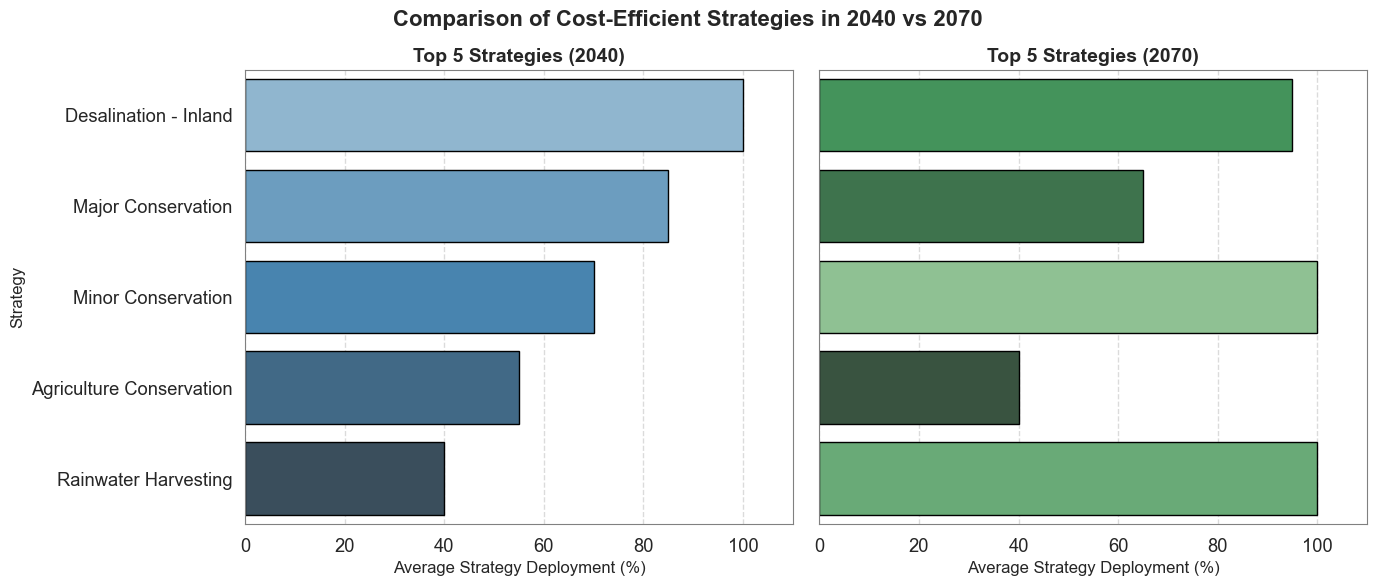


📋 Summary Table of Top Strategies:
 Year                 Strategy  Average Strategy Deployment (%)
 2040    Desalination - Inland                            100.0
 2040       Major Conservation                             85.0
 2040       Minor Conservation                             70.0
 2040 Agriculture Conservation                             55.0
 2040     Rainwater Harvesting                             40.0
 2070       Minor Conservation                            100.0
 2070     Rainwater Harvesting                            100.0
 2070    Desalination - Inland                             95.0
 2070       Major Conservation                             65.0
 2070 Agriculture Conservation                             40.0


In [15]:
# --- 6. Visualizations ---
# 2040 top strategies (example values based on your visualization)
top_strategies_2040 = {
    'Desalination - Inland': 1.0,
    'Major Conservation': 0.85,
    'Minor Conservation': 0.7,
    'Agriculture Conservation': 0.55,
    'Rainwater Harvesting': 0.4
}

# 2070 top strategies
top_strategies_2070 = {
    'Minor Conservation': 1.0,
    'Rainwater Harvesting': 1.0,
    'Desalination - Inland': 0.95,
    'Major Conservation': 0.65,
    'Agriculture Conservation': 0.4
}

# Convert to DataFrames
df_2040 = pd.DataFrame(list(top_strategies_2040.items()), columns=['Strategy', 'Average Strategy Deployment (%)'])
df_2040['Year'] = 2040
df_2070 = pd.DataFrame(list(top_strategies_2070.items()), columns=['Strategy', 'Average Strategy Deployment (%)'])
df_2070['Year'] = 2070

df_2040['Average Strategy Deployment (%)'] *= 100
df_2070['Average Strategy Deployment (%)'] *= 100

# Set style
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.edgecolor": "gray", "axes.linewidth": 0.8})

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 2040 Plot
sns.barplot(
    x='Average Strategy Deployment (%)',
    y='Strategy',
    data=df_2040,
    ax=axes[0],
    palette='Blues_d',
    edgecolor='black'
)
axes[0].set_title('Top 5 Strategies (2040)', fontsize=14, weight='bold')
axes[0].set_xlim(0, 110)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Average Strategy Deployment (%)', fontsize=12)
axes[0].set_ylabel('Strategy', fontsize=12)

# 2070 Plot
sns.barplot(
    x='Average Strategy Deployment (%)',
    y='Strategy',
    data=df_2070,
    ax=axes[1],
    palette='Greens_d',
    edgecolor='black'
)
axes[1].set_title('Top 5 Strategies (2070)', fontsize=14, weight='bold')
axes[1].set_xlim(0, 110)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Average Strategy Deployment (%)', fontsize=12)
axes[1].set_ylabel('')


# --- Overall Title ---
fig.suptitle('Comparison of Cost-Efficient Strategies in 2040 vs 2070', fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# --- Summary Table ---
summary_table = pd.concat([df_2040, df_2070], axis=0).sort_values(by=["Year", "Average Strategy Deployment (%)"], ascending=[True, False])
summary_table = summary_table[['Year', 'Strategy', 'Average Strategy Deployment (%)']]

print("\n📋 Summary Table of Top Strategies:")
print(summary_table.to_string(index=False))

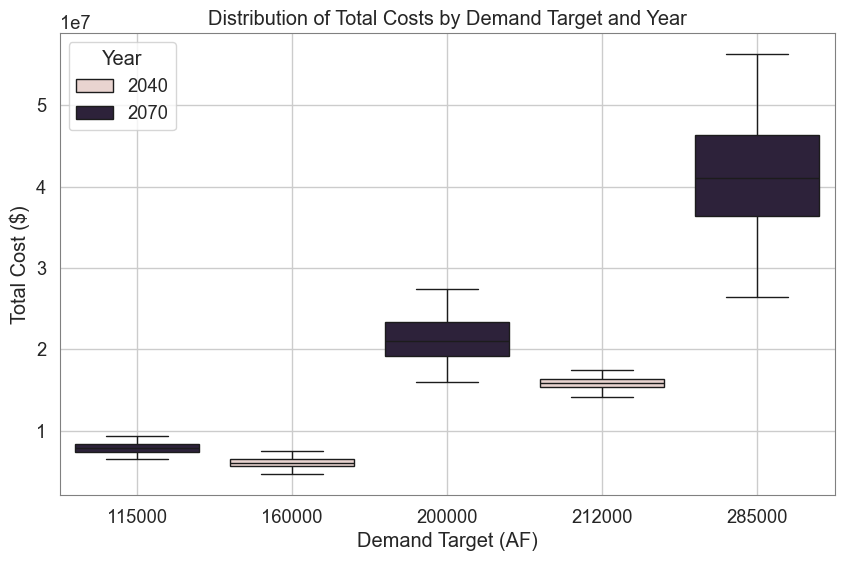

In [16]:
# Combine 2040 and 2070 results
combined_results = pd.concat([results_2040, results_2070])

plt.figure(figsize=(10,6))
sns.boxplot(data=combined_results, x="Demand Target", y="Total Cost ($)", hue="Year")
plt.title("Distribution of Total Costs by Demand Target and Year")
plt.ylabel("Total Cost ($)")
plt.xlabel("Demand Target (AF)")
plt.grid(True)
plt.show()

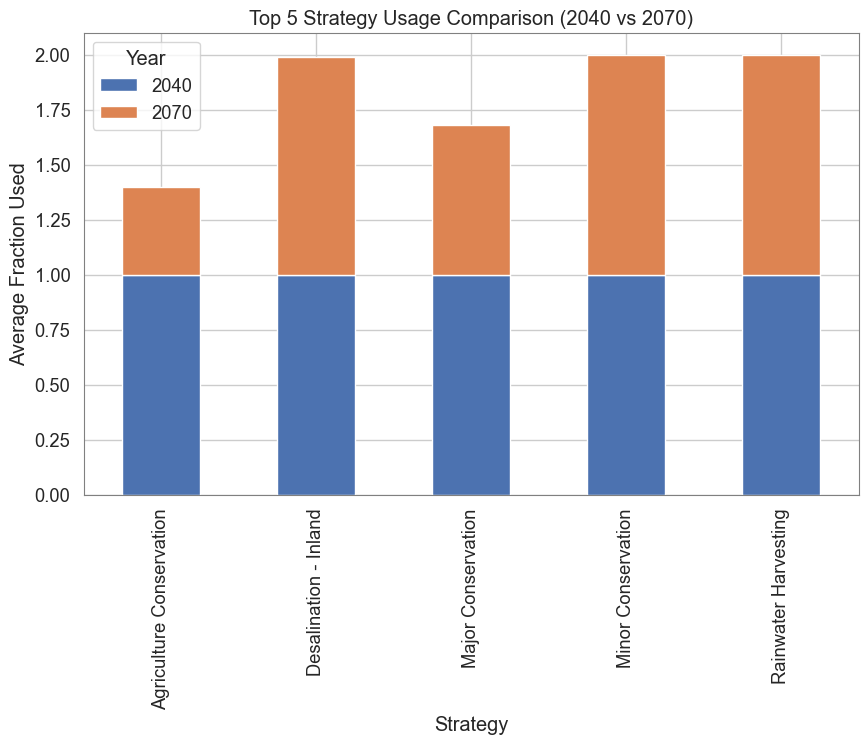

In [17]:
# Combine strategy usage into DataFrames
strategy_usage_2040 = pd.DataFrame(all_strategy_usage_2040)
strategy_usage_2070 = pd.DataFrame(all_strategy_usage_2070)

# Average usage
avg_usage_2040 = all_strategy_usage_2040.mean().sort_values(ascending=False)
avg_usage_2070 = all_strategy_usage_2070.mean().sort_values(ascending=False)

# Select Top 5
top5_2040 = avg_usage_2040.head(5)
top5_2070 = avg_usage_2070.head(5)

# Stacked bar
avg_usage_combined = pd.DataFrame({
    "2040": top5_2040,
    "2070": top5_2070
}).fillna(0)

avg_usage_combined.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Top 5 Strategy Usage Comparison (2040 vs 2070)")
plt.ylabel("Average Fraction Used")
plt.xlabel("Strategy")
plt.legend(title="Year")
plt.grid(True)
plt.show()

In [18]:
# Check total available supplies
total_supply_2040 = supplies_2040.sum()
total_supply_2070 = supplies_2070.sum()

print(f"Total Available Supply in 2040: {total_supply_2040:.2f} AF")
print(f"Total Available Supply in 2070: {total_supply_2070:.2f} AF")

# Compare with demand
print(f"Demand Target for 275,000 AF")

if total_supply_2040 < 275000:
    print(f"⚠️ In 2040, available supply ({total_supply_2040:.2f}) is LESS than 275,000 ➔ No feasible solution!")
else:
    print(f"✅ 2040 is feasible.")

if total_supply_2070 < 275000:
    print(f"⚠️ In 2070, available supply ({total_supply_2070:.2f}) is LESS than 275,000 ➔ No feasible solution!")
else:
    print(f"✅ 2070 is feasible.")

Total Available Supply in 2040: 244000.00 AF
Total Available Supply in 2070: 532000.00 AF
Demand Target for 275,000 AF
⚠️ In 2040, available supply (244000.00) is LESS than 275,000 ➔ No feasible solution!
✅ 2070 is feasible.


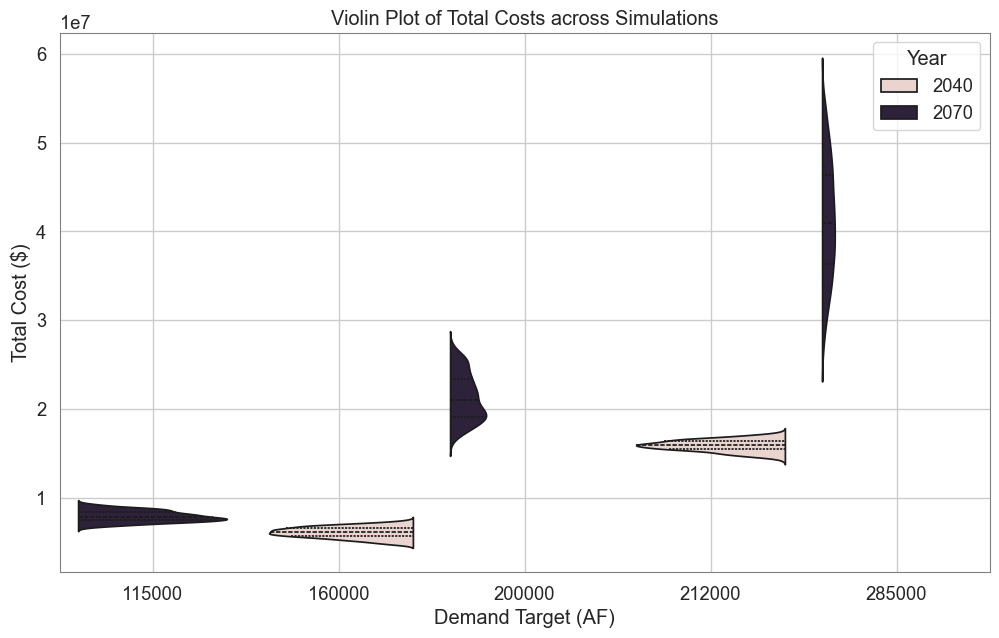

In [19]:
plt.figure(figsize=(12,7))

sns.violinplot(data=combined_results, x="Demand Target", y="Total Cost ($)", hue="Year", split=True, inner="quartile")

plt.title("Violin Plot of Total Costs across Simulations")
plt.ylabel("Total Cost ($)")
plt.xlabel("Demand Target (AF)")
plt.grid(True)
plt.show()

In [20]:
# --- 1. Extract from your loaded DataFrame (`df`) ---
strategies     = df["Strategy"].tolist()
supplies       = df["Supply_2040 (AF/yr)"].values.astype(float)
capital_cost   = df["Total Capital Cost (Million $ )"].values.astype(float)
om_low_2040    = df["O&M cost_Low_2040 (Million $)"].values.astype(float)
om_high_2040   = df["O&M cost_High_2040 (Million $)"].values.astype(float)
om_low_2070    = df["O&M cost_Low_2070 (Million $)"].values.astype(float)
om_high_2070   = df["O&M cost_High_2070 (Million $)"].values.astype(float)
resilience     = df["Resilience Score (1-5)"].values
feasibility    = df["Feasibility Score (1-5)"].values

# Precompute a single “representative” cost per AF (capital + mean O&M)
total_cost_2040 = capital_cost + 0.5*(om_low_2040 + om_high_2040)  # in M$
total_cost_2070 = capital_cost + 0.5*(om_low_2070 + om_high_2070)  # in M$

In [21]:
# --- 2. GA & DEAP Boilerplate ---
POP_SIZE   = 100
N_GEN      = 100
CX_PB      = 0.9
MUT_PB     = 0.1

In [22]:
# Create our multi-objective fitness: minimize cost, maximize resil & feas
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)  # uniform [0,1]
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=len(strategies))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [23]:
# --- 3. Evaluation Function ---

def evaluate(ind, supplies, costs, resil, feas, demand):
    x = np.clip(ind, 0.0, 1.0)
    total_supply = float(np.dot(x, supplies))
    # penalty for unmet demand
    penalty = float(max(0.0, demand - total_supply)) * 1000

    cost_val = float(np.dot(x * supplies, costs)) + penalty
    if x.sum() > 0:
        resil_val = float(np.dot(x, resil) / x.sum())
        feas_val  = float(np.dot(x, feas) / x.sum())
    else:
        resil_val = 0.0
        feas_val  = 0.0

    # return plain Python floats, not numpy types
    return cost_val, resil_val, feas_val


In [24]:
# Register GA operators
toolbox.register("mate",   tools.cxSimulatedBinaryBounded,
                 low=0.0, up=1.0, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded,
                 low=0.0, up=1.0, eta=20.0,
                 indpb=1.0/len(strategies))
toolbox.register("select", tools.selNSGA2)

In [25]:
# --- 4. GA Runner ----------------------------
def run_ga(supplies, costs, resil, feas, demands):
    pareto_fronts = {}
    for D in demands:
        # fresh population each target
        pop = toolbox.population(n=POP_SIZE)
        # bind evaluate for this D
        toolbox.register("evaluate",
                         lambda ind: evaluate(ind, supplies, costs, resil, feas, D))
        # run NSGA-II
        pop, _ = algorithms.eaMuPlusLambda(
            pop, toolbox,
            mu=POP_SIZE, lambda_=POP_SIZE,
            cxpb=CX_PB, mutpb=MUT_PB,
            ngen=N_GEN, verbose=False
        )
        # extract first (best) Pareto front
        front = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
        pareto_fronts[D] = front
    return pareto_fronts

In [26]:
# --- 5. Execute for your 2040 and 2070 targets ----------
demand_targets_2040 = [160000, 212000, 275000]
demand_targets_2070 = [115000, 200000, 285000]
results_2040 = run_ga(supplies, total_cost_2040, resilience, feasibility, demand_targets_2040)
results_2070 = run_ga(supplies, total_cost_2070, resilience, feasibility, demand_targets_2070)

In [27]:
results_2040  # {160000: [ind1, ind2, …], 212000: […], 275000: […]}
results_2070  # {115000: […], 200000: […], 285000: […]}
strategies    # list of strategy names, in same order as your individuals

['AWP',
 'Desalination - Inland',
 'Desalination - Coastal',
 'Major Conservation',
 'Minor Conservation',
 'Agriculture Conservation',
 'Rainwater Harvesting']

In [28]:
def select_best(front):
    # Score = (resilience + feasibility) / cost
    scores = [
        ((ind.fitness.values[1] + ind.fitness.values[2]) / ind.fitness.values[0], ind)
        for ind in front
    ]
    _, best = max(scores, key=lambda x: x[0])
    return best

# --- 1) Collect the best solution for every year & demand ---
best_solutions = []
for year, results in [(2040, results_2040), (2070, results_2070)]:
    for demand, front in results.items():
        best = select_best(front)
        c, r, f = best.fitness.values
        best_solutions.append({
            "Year": year,
            "Demand (AF)": demand,
            "Cost (M$)": c,
            "Resilience": r,
            "Feasibility": f,
        })

In [29]:
df_best = pd.DataFrame(best_solutions)
df_best["Cost (M$)"] = df_best["Cost (M$)"] / 1e6
print(df_best[["Year","Demand (AF)","Cost (M$)", "Resilience","Feasibility"]])

   Year  Demand (AF)   Cost (M$)  Resilience  Feasibility
0  2040       160000    8.620506    3.952383     2.675996
1  2040       212000   18.423922    3.843423     2.808004
2  2040       275000   59.032368    3.633933     2.712875
3  2070       115000   14.903848    4.047985     2.562230
4  2070       200000   52.066966    3.820727     2.822154
5  2070       285000  119.340338    3.735414     2.790598


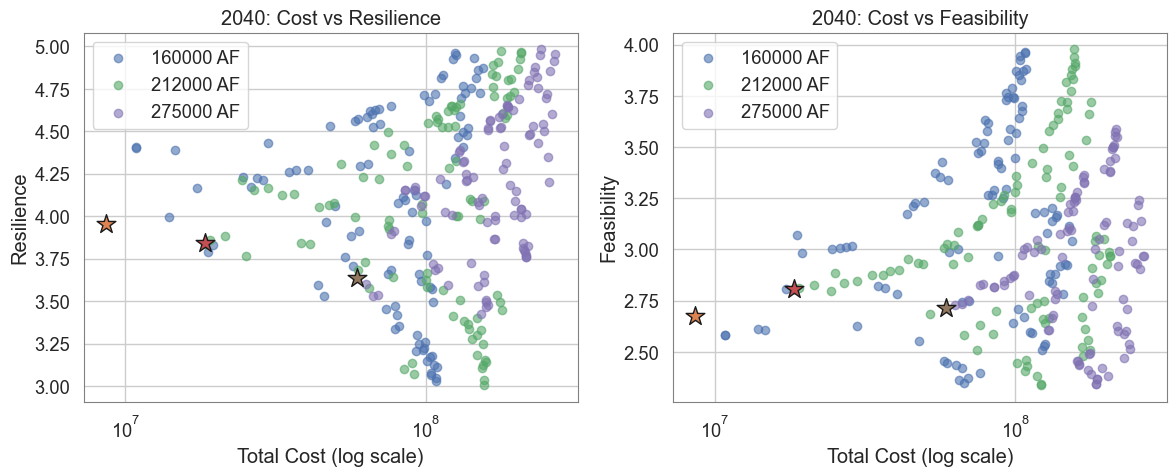

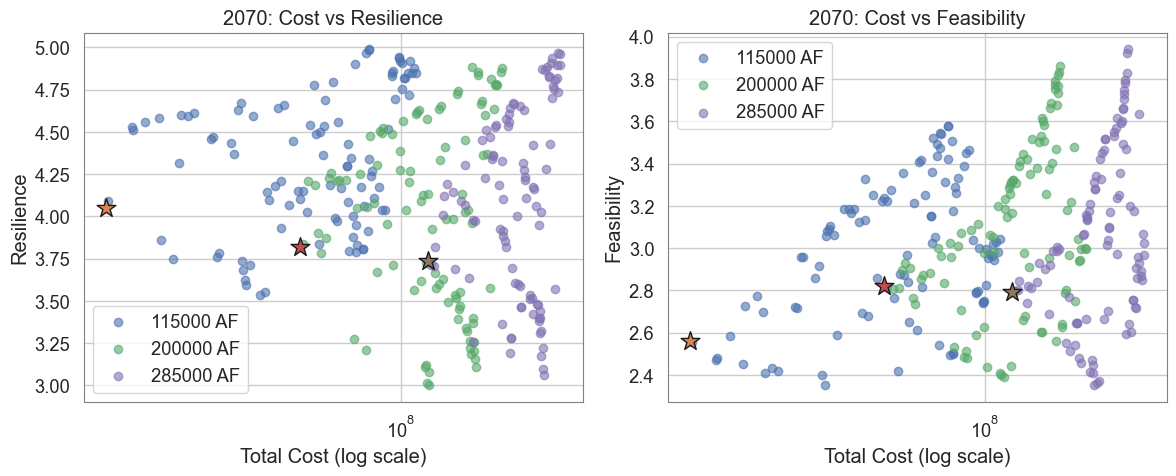

In [30]:
for year, results in [(2040, results_2040), (2070, results_2070)]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for demand, front in results.items():
        arr = np.array([ind.fitness.values for ind in front])
        cost_vals, resil_vals, feas_vals = arr[:,0], arr[:,1], arr[:,2]

        # scatter all front points
        ax1.scatter(cost_vals, resil_vals, label=f"{demand} AF", alpha=0.6)
        ax2.scatter(cost_vals, feas_vals,  label=f"{demand} AF", alpha=0.6)

        # overlay the “best” solution
        best = select_best(front)
        c_best, r_best, f_best = best.fitness.values
        ax1.scatter(c_best, r_best, marker='*', s=200, edgecolor='k')
        ax2.scatter(c_best, f_best, marker='*', s=200, edgecolor='k')

    for ax, title, ylabel in zip(
        (ax1, ax2),
        (f"{year}: Cost vs Resilience", f"{year}: Cost vs Feasibility"),
        ("Resilience", "Feasibility")
    ):
        ax.set_xscale('log')
        ax.set_title(title)
        ax.set_xlabel("Total Cost (log scale)")
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.tight_layout()
    plt.show()


=== 2040 Best Strategy Mixes ===


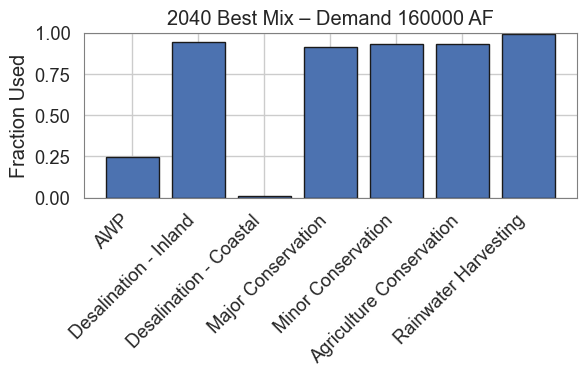

--- Demand: 160000 AF ---
  AWP                      : 0.25
  Desalination - Inland    : 0.94
  Desalination - Coastal   : 0.01
  Major Conservation       : 0.91
  Minor Conservation       : 0.93
  Agriculture Conservation : 0.93
  Rainwater Harvesting     : 0.99



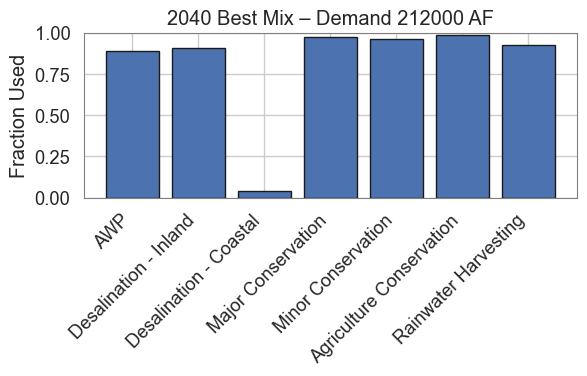

--- Demand: 212000 AF ---
  AWP                      : 0.89
  Desalination - Inland    : 0.90
  Desalination - Coastal   : 0.04
  Major Conservation       : 0.97
  Minor Conservation       : 0.96
  Agriculture Conservation : 0.99
  Rainwater Harvesting     : 0.92



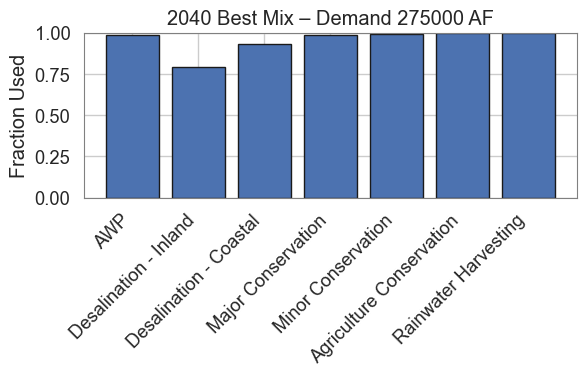

--- Demand: 275000 AF ---
  AWP                      : 0.99
  Desalination - Inland    : 0.79
  Desalination - Coastal   : 0.93
  Major Conservation       : 0.98
  Minor Conservation       : 0.99
  Agriculture Conservation : 1.00
  Rainwater Harvesting     : 0.99


=== 2070 Best Strategy Mixes ===


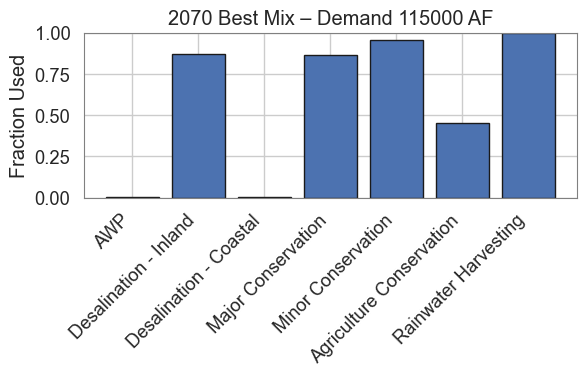

--- Demand: 115000 AF ---
  Desalination - Inland    : 0.87
  Major Conservation       : 0.86
  Minor Conservation       : 0.95
  Agriculture Conservation : 0.45
  Rainwater Harvesting     : 1.00



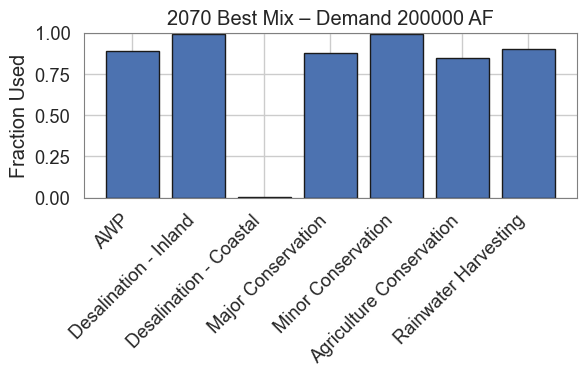

--- Demand: 200000 AF ---
  AWP                      : 0.89
  Desalination - Inland    : 0.99
  Major Conservation       : 0.87
  Minor Conservation       : 0.99
  Agriculture Conservation : 0.84
  Rainwater Harvesting     : 0.90



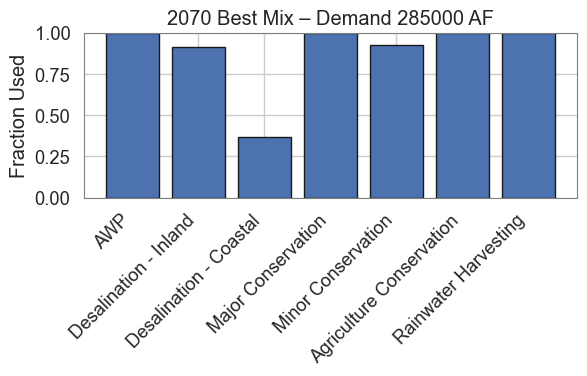

--- Demand: 285000 AF ---
  AWP                      : 1.00
  Desalination - Inland    : 0.91
  Desalination - Coastal   : 0.37
  Major Conservation       : 1.00
  Minor Conservation       : 0.93
  Agriculture Conservation : 1.00
  Rainwater Harvesting     : 1.00



In [31]:
# --- 3) Bar‐chart best mixes & print them ---
for year, results in [ (2040, results_2040), (2070, results_2070) ]:
    print(f"\n=== {year} Best Strategy Mixes ===")
    for demand, front in results.items():
        best = select_best(front)
        # Bar chart of fractions
        plt.figure(figsize=(6,4))
        plt.bar(strategies, best, edgecolor='k')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0,1)
        plt.ylabel("Fraction Used")
        plt.title(f"{year} Best Mix – Demand {demand} AF")
        plt.tight_layout()
        plt.show()
        # Print to console
        print(f"--- Demand: {demand} AF ---")
        for strat, frac in zip(strategies, best):
            if frac > 0.01:
                print(f"  {strat:25s}: {frac:.2f}")
        print()

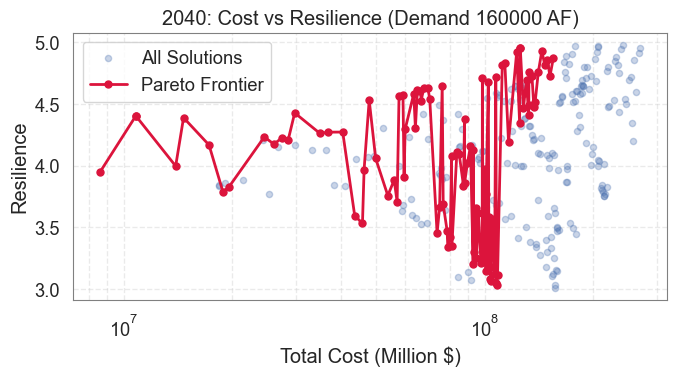

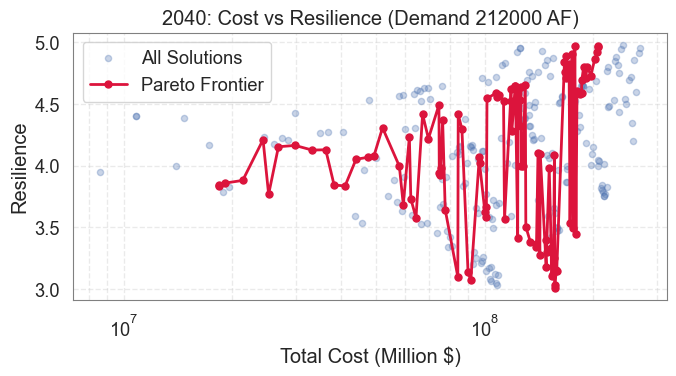

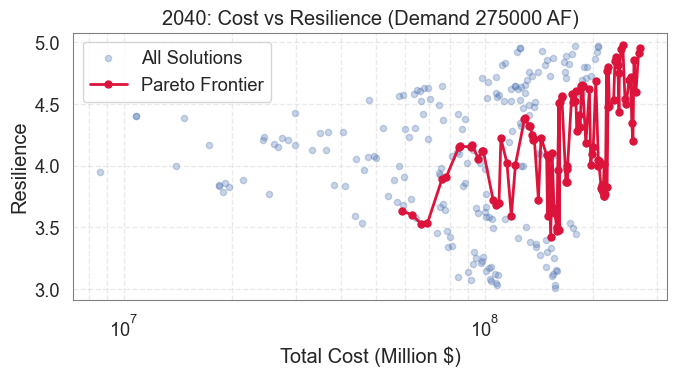

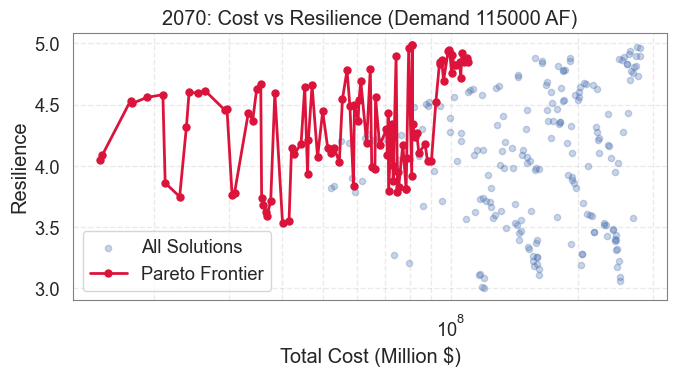

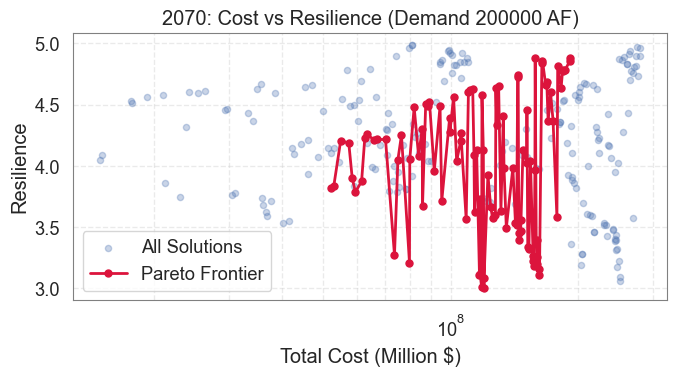

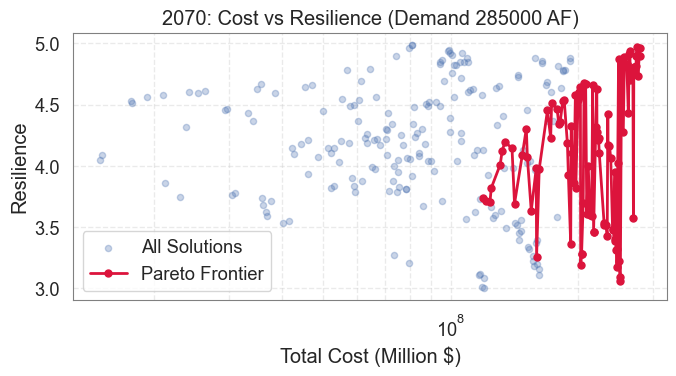

In [32]:
def plot_pareto_overlay(front, all_inds, year, demand):
    # Extract fitness arrays
    all_fits = np.array([ind.fitness.values for ind in all_inds])
    frontier_fits = np.array([ind.fitness.values for ind in front])
    
    # Sort frontier by cost
    idx = np.argsort(frontier_fits[:,0])
    frontier_cost = frontier_fits[idx, 0]
    frontier_res  = frontier_fits[idx, 1]
    
    # Plot
    plt.figure(figsize=(7,4))
    plt.scatter(all_fits[:,0], all_fits[:,1],
                alpha=0.3, s=20, label='All Solutions')
    plt.plot(frontier_cost, frontier_res,
             '-o', color='crimson', lw=2, markersize=5,
             label='Pareto Frontier')
    plt.xscale('log')
    plt.xlabel('Total Cost (Million $)')
    plt.ylabel('Resilience')
    plt.title(f'{year}: Cost vs Resilience (Demand {demand} AF)')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Example usage for one demand in 2040:
all_individuals = [ind for front in results_2040.values() for ind in front]
plot_pareto_overlay(results_2040[160000], all_individuals, year=2040, demand=160000)
plot_pareto_overlay(results_2040[212000], all_individuals, year=2040, demand=212000)
plot_pareto_overlay(results_2040[275000], all_individuals, year=2040, demand=275000)

# Example usage for one demand in 2070:
all_individuals = [ind for front in results_2070.values() for ind in front]
plot_pareto_overlay(results_2070[115000], all_individuals, year=2070, demand=115000)
plot_pareto_overlay(results_2070[200000], all_individuals, year=2070, demand=200000)
plot_pareto_overlay(results_2070[285000], all_individuals, year=2070, demand=285000)

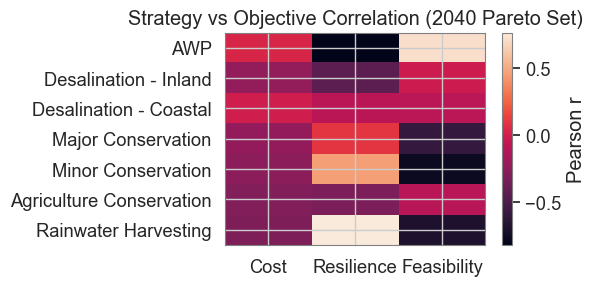

In [42]:
# 1) Gather Pareto solutions into a DataFrame
#   Replace results_2040 with results_2070 for the latter year
pareto_results = results_2040   # dict: demand→list of Individuals
strategies     = df['Strategy'].tolist()

records = []
for front in pareto_results.values():
    for ind in front:
        row = {s: frac for s, frac in zip(strategies, ind)}
        cost, resil, feas = ind.fitness.values
        row.update({'Cost': cost,
                    'Resilience': resil,
                    'Feasibility': feas})
        records.append(row)

df_pareto_2040= pd.DataFrame(records)
df_pareto_2040.to_csv("solutions_2040.csv", index=False)
# 2) Compute Pearson correlations between each strategy and each objective
cols = strategies + ['Cost', 'Resilience', 'Feasibility']
corr = df_pareto[cols].corr()
corr_strat_obj = corr.loc[strategies, ['Cost','Resilience','Feasibility']]

# 3) Plot the heatmap
plt.figure(figsize=(6, len(strategies)*0.3 + 1))
plt.imshow(corr_strat_obj, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(np.arange(3), ['Cost','Resilience','Feasibility'])
plt.yticks(np.arange(len(strategies)), strategies)
plt.title('Strategy vs Objective Correlation (2040 Pareto Set)')
plt.tight_layout()
plt.show()

In [44]:
df_pareto_2040.head()

,AWP,Desalination - Inland,Desalination - Coastal,Major Conservation,Minor Conservation,Agriculture Conservation,Rainwater Harvesting,Cost,Resilience,Feasibility
0,0.248281,0.943152,0.011742,0.914432,0.933091,0.933191,0.988223,8.620506e+06,3.952383,2.675996
1,0.025084,0.004210,0.012393,0.972254,0.982042,0.040423,0.946034,6.773350e+07,4.626932,2.348988
2,0.032284,0.004246,0.000510,0.001280,0.967589,0.002822,0.973608,1.251871e+08,4.958162,2.527278
3,0.036222,0.004188,0.000510,0.000460,0.008044,0.001497,0.647342,1.550484e+08,4.873266,3.038965
4,0.934807,0.003929,0.000825,0.000913,0.007914,0.002303,0.007666,1.079505e+08,3.030908,3.965354


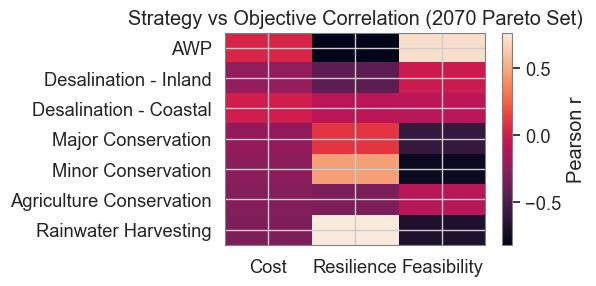

In [43]:
pareto_results = results_2070   # dict: demand→list of Individuals
strategies     = df['Strategy'].tolist()

records = []
for front in pareto_results.values():
    for ind in front:
        row = {s: frac for s, frac in zip(strategies, ind)}
        cost, resil, feas = ind.fitness.values
        row.update({'Cost': cost,
                    'Resilience': resil,
                    'Feasibility': feas})
        records.append(row)

df_pareto_2070 = pd.DataFrame(records)
df_pareto_2070.to_csv("solutions_2070.csv", index=False)
# 2) Compute Pearson correlations between each strategy and each objective
cols = strategies + ['Cost', 'Resilience', 'Feasibility']
corr = df_pareto[cols].corr()
corr_strat_obj = corr.loc[strategies, ['Cost','Resilience','Feasibility']]

# 3) Plot the heatmap
plt.figure(figsize=(6, len(strategies)*0.3 + 1))
plt.imshow(corr_strat_obj, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(np.arange(3), ['Cost','Resilience','Feasibility'])
plt.yticks(np.arange(len(strategies)), strategies)
plt.title('Strategy vs Objective Correlation (2070 Pareto Set)')
plt.tight_layout()
plt.show()

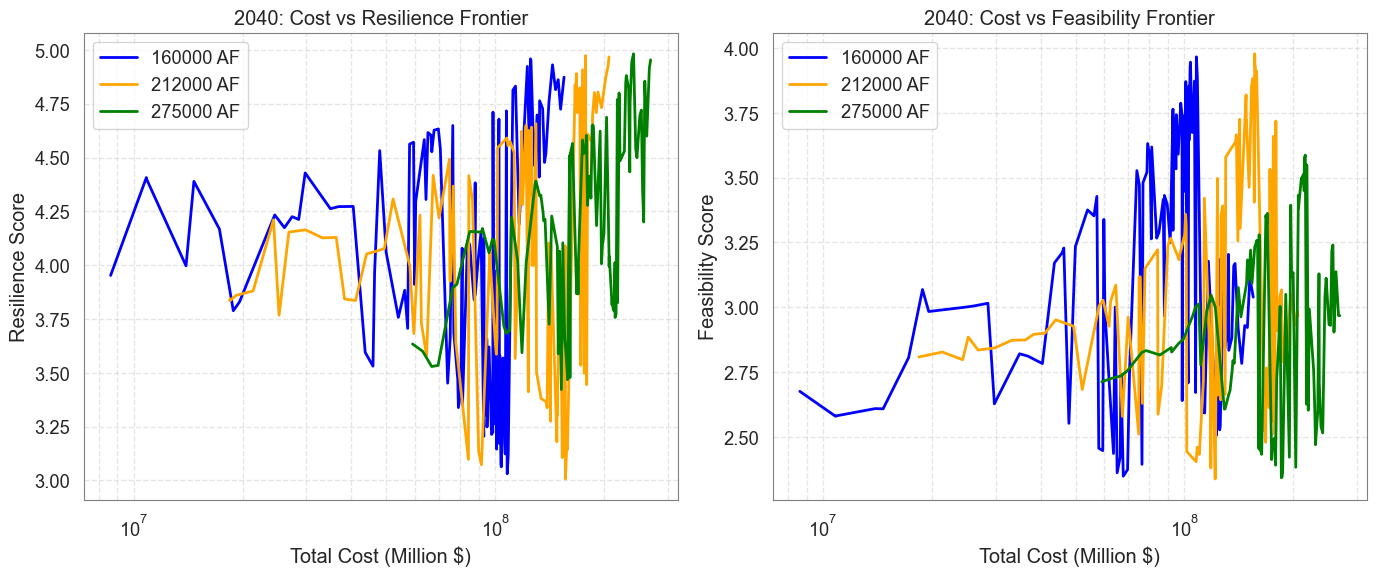

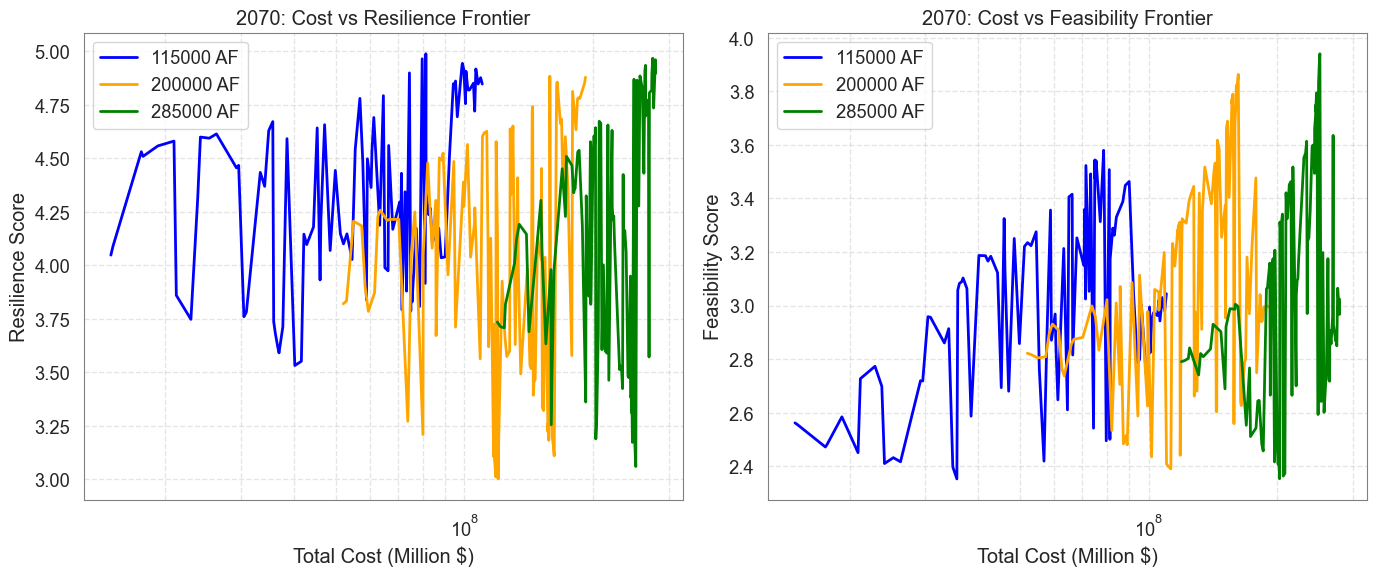

In [35]:
def plot_pareto_frontiers(results, year):
    """
    results: dict mapping demand_target -> list of Pareto-optimal Individuals
    year:    int (e.g. 2040 or 2070), used in titles
    """
    demands = sorted(results.keys())
    # assign distinct colors
    cmap = {demands[0]:'blue', demands[1]:'orange', demands[2]:'green'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharex=False)

    # Panel 1: Cost vs Resilience
    for d in demands:
        pts = np.array([ind.fitness.values for ind in results[d]])
        # sort by cost
        idx = np.argsort(pts[:,0])
        cost, resil = pts[idx,0], pts[idx,1]
        ax1.plot(cost, resil, color=cmap[d], lw=2, label=f"{d} AF")
    ax1.set_xscale('log')
    ax1.set_xlabel("Total Cost (Million $)")
    ax1.set_ylabel("Resilience Score")
    ax1.set_title(f"{year}: Cost vs Resilience Frontier")
    ax1.legend()
    ax1.grid(True, which='both', ls='--', alpha=0.5)

    # Panel 2: Cost vs Feasibility
    for d in demands:
        pts = np.array([ind.fitness.values for ind in results[d]])
        idx = np.argsort(pts[:,0])
        cost, feas = pts[idx,0], pts[idx,2]
        ax2.plot(cost, feas, color=cmap[d], lw=2, label=f"{d} AF")
    ax2.set_xscale('log')
    ax2.set_xlabel("Total Cost (Million $)")
    ax2.set_ylabel("Feasibility Score")
    ax2.set_title(f"{year}: Cost vs Feasibility Frontier")
    ax2.legend()
    ax2.grid(True, which='both', ls='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_pareto_frontiers(results_2040, 2040)
plot_pareto_frontiers(results_2070, 2070)

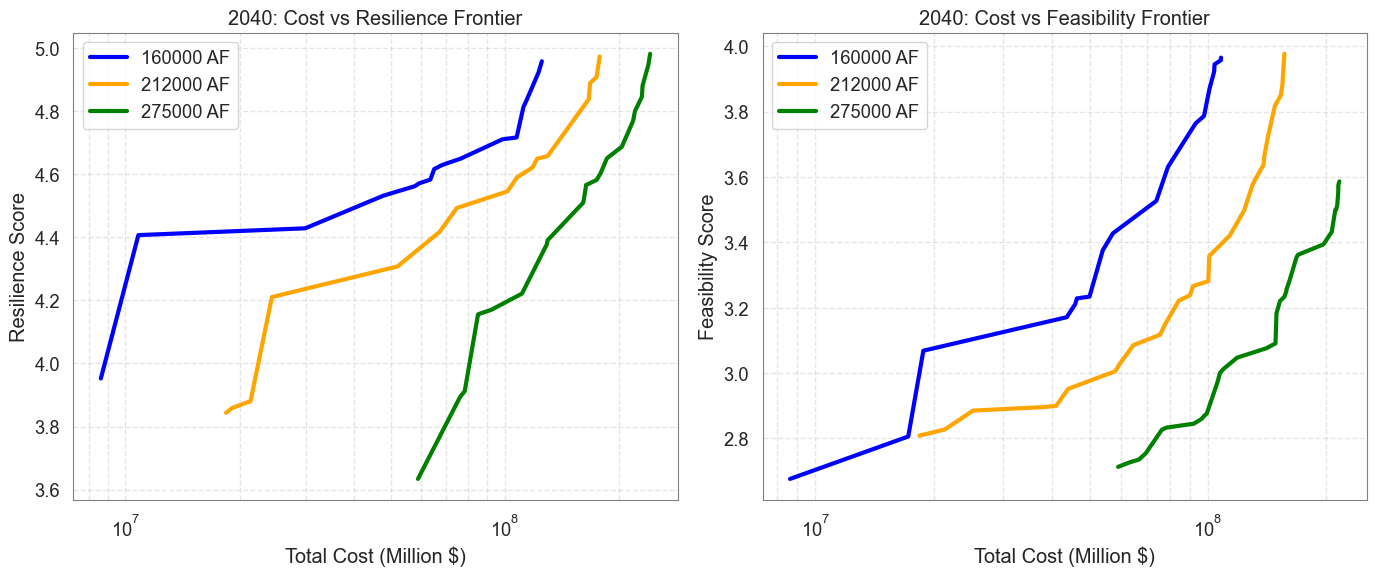

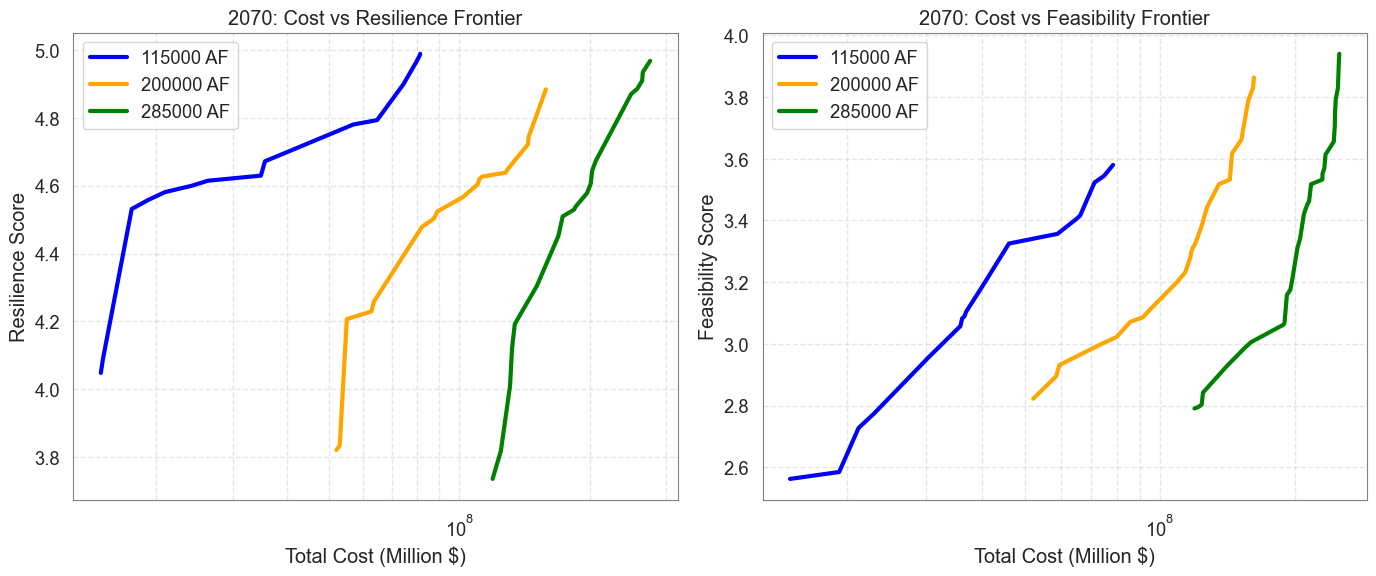

In [36]:
def extract_2d_front(front, idx_x, idx_y):
    """
    Given a list of individuals and two fitness indices,
    returns the monotonic 2D Pareto front (x,y) sorted by x ascending.
    """
    # pull out just the two objectives
    pts = np.array([ind.fitness.values for ind in front])[:, [idx_x, idx_y]]
    # sort by x
    order = np.argsort(pts[:,0])
    pts_sorted = pts[order]
    # sweep, keeping only points that improve y
    front_pts = []
    best_y = -np.inf
    for x, y in pts_sorted:
        if y > best_y:
            front_pts.append((x, y))
            best_y = y
    return zip(*front_pts)  # returns (xs, ys)

def plot_clean_frontiers(results, year):
    demands = sorted(results.keys())
    colors  = {demands[0]:'blue', demands[1]:'orange', demands[2]:'green'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

    # Cost vs Resilience (idx_x=0, idx_y=1)
    for d in demands:
        x_r, y_r = extract_2d_front(results[d], idx_x=0, idx_y=1)
        ax1.plot(x_r, y_r, color=colors[d], lw=3, label=f"{d} AF")
    ax1.set_xscale('log')
    ax1.set_xlabel("Total Cost (Million $)")
    ax1.set_ylabel("Resilience Score")
    ax1.set_title(f"{year}: Cost vs Resilience Frontier")
    ax1.legend()
    ax1.grid(True, which='both', ls='--', alpha=0.5)

    # Cost vs Feasibility (idx_x=0, idx_y=2)
    for d in demands:
        x_f, y_f = extract_2d_front(results[d], idx_x=0, idx_y=2)
        ax2.plot(x_f, y_f, color=colors[d], lw=3, label=f"{d} AF")
    ax2.set_xscale('log')
    ax2.set_xlabel("Total Cost (Million $)")
    ax2.set_ylabel("Feasibility Score")
    ax2.set_title(f"{year}: Cost vs Feasibility Frontier")
    ax2.legend()
    ax2.grid(True, which='both', ls='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Usage:
plot_clean_frontiers(results_2040, 2040)
plot_clean_frontiers(results_2070, 2070)

In [37]:
# Build a list of records from your GA “best mixes”
records = []
for year, results in [(2040, results_2040), (2070, results_2070)]:
    for demand, front in results.items():
        best_ind = select_best(front)  
        row = {'Year': year, 'Demand (AF)': demand}
        # record each strategy’s fraction
        for strat, frac in zip(strategies, best_ind):
            row[strat] = frac
        records.append(row)

# Create DataFrame
df_best_mixes = pd.DataFrame(records)

# Display nicely
display(
    df_best_mixes
      .set_index(['Year','Demand (AF)'])
      .style
      .format("{:.2f}")
      .set_caption("Best Strategy Mixes (Fraction of Capacity)")
)

In [38]:
supplies = {
    2040: df.set_index('Strategy')['Supply_2040 (AF/yr)'].to_dict(),
    2070: df.set_index('Strategy')['Supply_2070 (AF/yr)'].to_dict()
}

In [39]:
# --- 3) Compute actual volumes, normalize to percentages ---
strat_cols = [c for c in df_best_mixes.columns if c not in ['Year','Demand (AF)']]
pct_records = []

for _, row in df_best_mixes.iterrows():
    year = row['Year']
    demand = row['Demand (AF)']
    supply_map = supplies[year]
    volumes = {s: row[s] * supply_map[s] for s in strat_cols}
    total_vol = sum(volumes.values()) or np.nan
    pct_row = {'Year': year, 'Demand (AF)': demand}
    for s in strat_cols:
        pct_row[s] = (volumes[s] / total_vol * 100) if total_vol else np.nan
    pct_records.append(pct_row)

df_pct = pd.DataFrame(pct_records)

In [40]:
# 4) Filter extremes
extremes = [(2040,160000),(2040,275000),(2070,115000),(2070,285000)]
df_pct = df_pct.set_index(['Year','Demand (AF)']).loc[extremes].reset_index()

# 5) Replace exact zeros with NaN
df_pct.replace(0, np.nan, inplace=True)

# 6) Display with na_rep
display(
    df_pct
      .set_index(['Year','Demand (AF)'])
      .style
      .format("{:.1f}%", na_rep="–")
      .set_caption("Best Mix % of Total Water Supplied")
)